# **1. Configuration du début de code**

In [13]:
import pandas as pd
import os

FILE_PATH = "dataset/en.openfoodfacts.org.products.csv"

CHUNK_SIZE = 10000
NUTRISCORE_GRADE =  ["a", "b", "c", "d", "e"]
COLS_TARGET = ['nutriscore_grade']
SEUIL_VALEURS_VIDES=20
OUTPUT_PATH = "dataset/openfoodfact_clean.csv"
OUTPUT_AFTER_CHUNK_PATH = "dataset/openfoodfact_after_chunk.csv"
UNKNOWN_COUTRY = "unknown"
COL_FOR_COUNTRY = "countries_en"

# **2. Récupération des données**

In [14]:
chunks = pd.read_csv(FILE_PATH, sep="\t", low_memory=False, header=0, chunksize=CHUNK_SIZE, on_bad_lines="skip")
list_df = []
for chunk in chunks:
  list_df.append(chunk)

# 3. **Actions de nettoyage**

### a. Nettoyer le nutriscore_grade

In [15]:
list_df_notna = []

for df in list_df:
  df_tmp = df[df[COLS_TARGET].notna().all(axis=1)]
  if len(df_tmp) > 0:
    list_df_notna.append(df_tmp)

    # Cette ne sera sûrement pas nécéssaire car il reste encore plus de 3 millions d'entrée. 
    # Lors de la création du script passer directement à la partie b

In [16]:
# On supprime les lignes qui sont en dehors des nutriscore a, b, c, d, e
list_df_in_grade = []

for df in list_df_notna: 
    df_tmp = df[df["nutriscore_grade"].isin(NUTRISCORE_GRADE)]
    if len(df_tmp) > 0:
        list_df_in_grade.append(df_tmp)

In [17]:
# On vérifie le nombre de lignes qui nous reste à la fin

n_rows = 0
for df in list_df_in_grade:
    n_rows += len(df)

n_rows

1156038

In [18]:
# Je fusionne la liste de Dataframe en Dataframe car c'est maintenant possible de le faire
df_clean = pd.concat(list_df_in_grade, ignore_index=False)

### b. Suppression des colonnes selon des pourcentages rempli

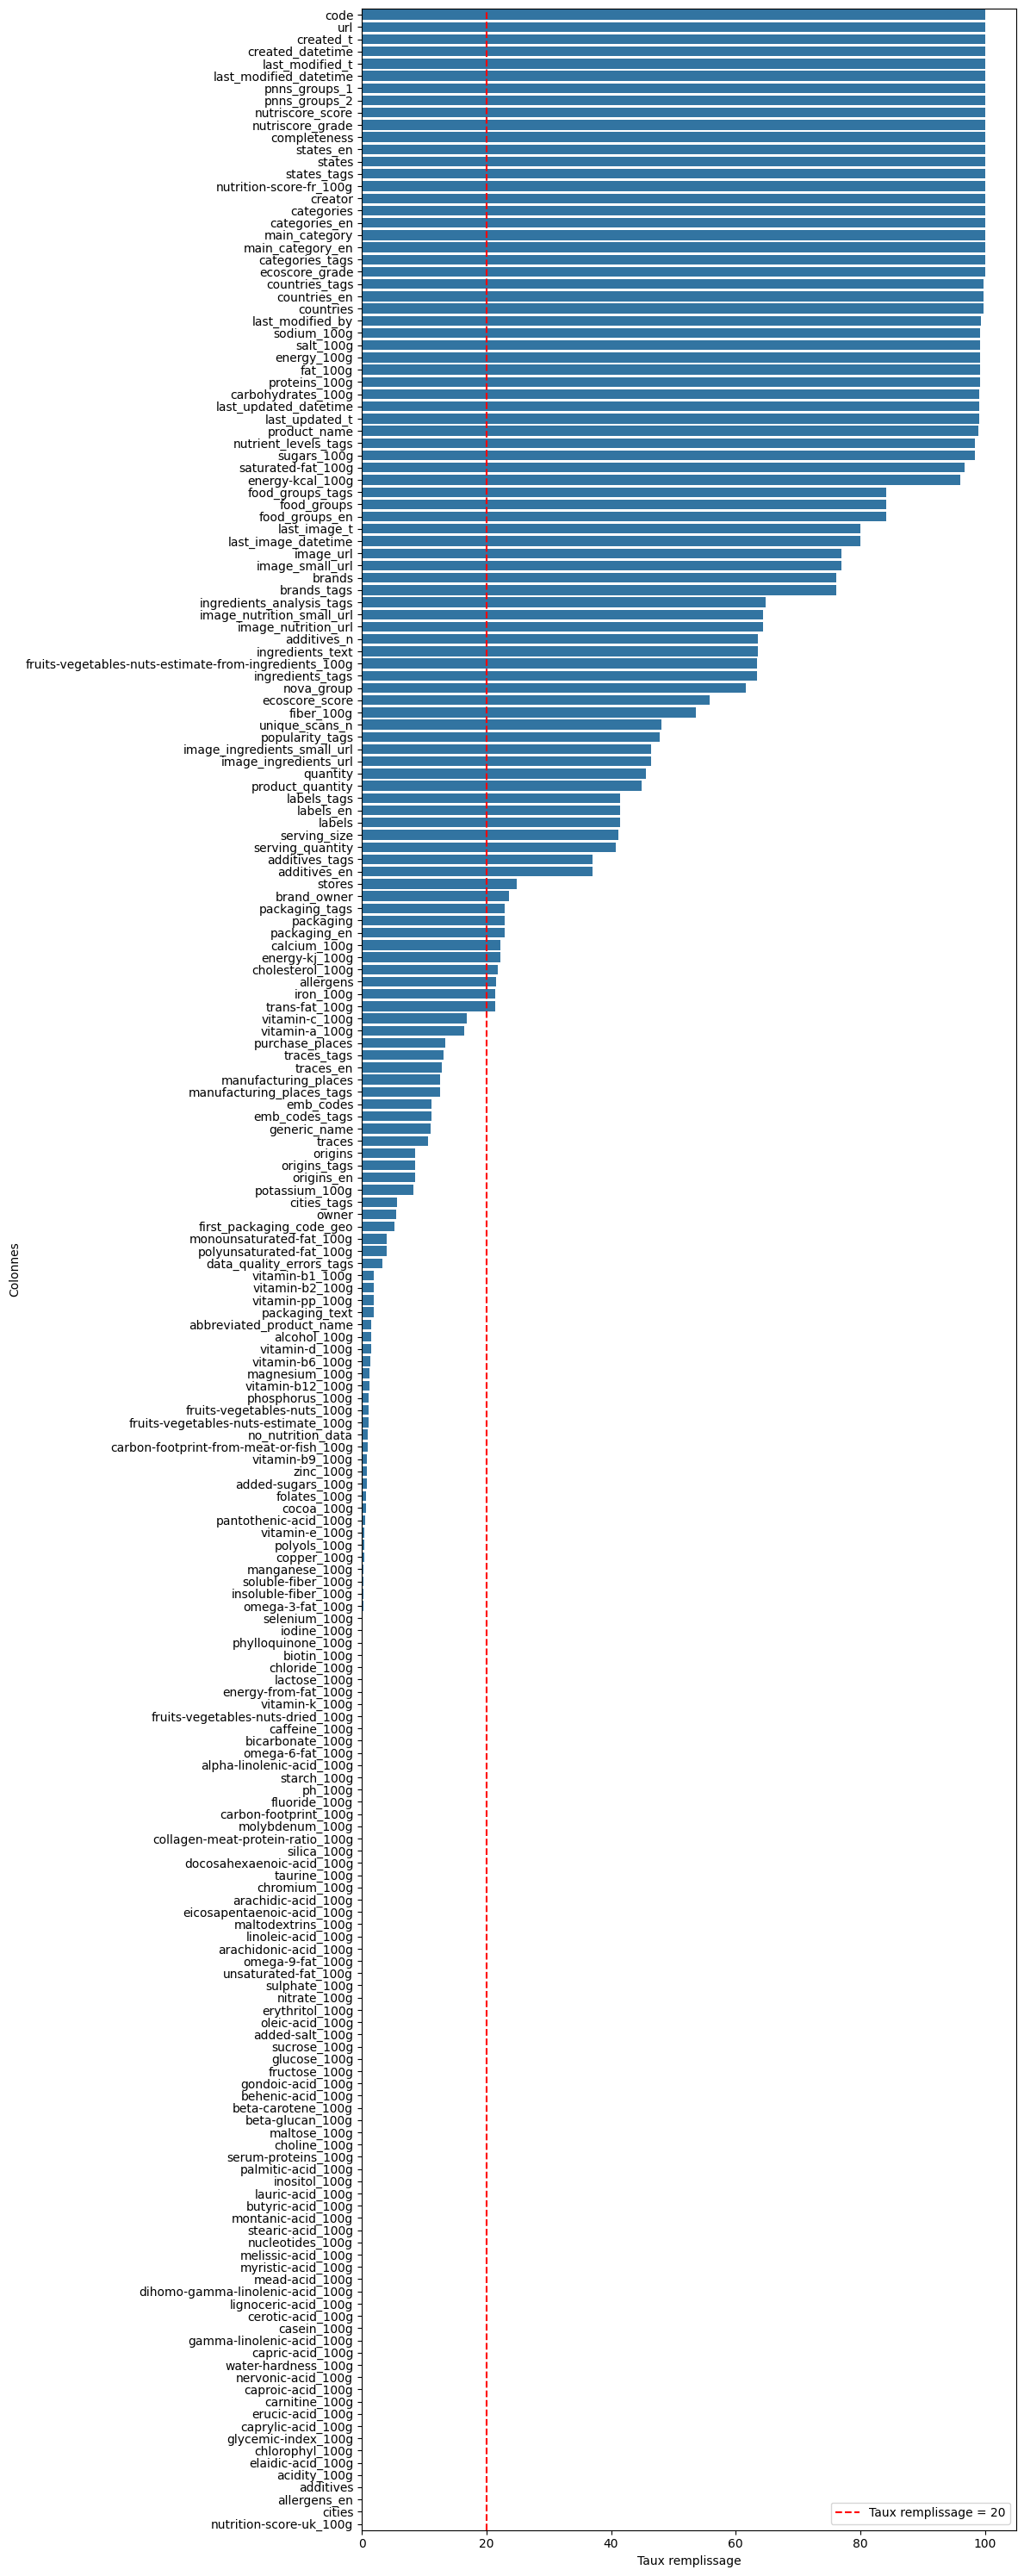

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calculer le taux de remplissage pour chaque colonne
valeurs = df_clean.notnull().mean() * 100
colonnes = df_clean.columns.astype(str)

# Créer un DataFrame pour le taux de remplissage
df_remplissage = pd.DataFrame({'Colonnes': colonnes, 'Taux remplissage': valeurs.values})

# Trier le DataFrame par taux de remplissage
df_sorted = df_remplissage.sort_values(by='Taux remplissage', ascending=False).reset_index(drop=True)

# Créer le graphique
plt.figure(figsize=(12, 30))  # Taille de la figure
sns.barplot(x='Taux remplissage', y='Colonnes', data=df_sorted, orient='h')
plt.axvline(x=SEUIL_VALEURS_VIDES, color='red', linestyle='--', label=f'Taux remplissage = {SEUIL_VALEURS_VIDES}')

# Afficher la légende et le graphique
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Stocker le taux de valeurs vides de chaque colonne directement dans un DataFrame
taux_remplissage_columns = df_clean.isnull().mean() * 100

# Créer un DataFrame des colonnes et du taux de valeurs vides
df_colonnes = pd.DataFrame({
    'Colonnes': df_clean.columns,
    'Taux valeurs vides': taux_remplissage_columns
})

# Sélectionner les colonnes dont le taux de valeurs vides est supérieur au seuil
empty_columns = df_colonnes.loc[df_colonnes['Taux valeurs vides'] > (100 - SEUIL_VALEURS_VIDES), 'Colonnes']

# Supprimer les colonnes identifiées
df_clean.drop(empty_columns, axis=1, inplace=True)

# Afficher les premières lignes du DataFrame nettoyé
df_clean.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition-score-fr_100g
0,1,http://world-en.openfoodfacts.org/product/0000...,inf,1634745456,2021-10-20T15:57:36Z,1729416368,2024-10-20T09:26:08Z,kris3,1.729416e+09,2024-10-20T09:26:08Z,...,6.70000,6.70000,NaN,80.000000,0.500000,0.200000,NaN,NaN,0.013317,12.0
3,4,http://world-en.openfoodfacts.org/product/0000...,elcoco,1560176426,2019-06-10T14:20:26Z,1728909934,2024-10-14T12:45:34Z,smoothie-app,1.728910e+09,2024-10-14T12:45:34Z,...,40.70000,35.00000,8.400000,7.500000,0.000000,0.000000,NaN,NaN,12.000000,19.0
4,5,http://world-en.openfoodfacts.org/product/0000...,touchette,1605337720,2020-11-14T07:08:40Z,1729432954,2024-10-20T14:02:34Z,roboto-app,1.729433e+09,2024-10-20T14:02:34Z,...,8.00000,8.00000,88.000000,0.000000,0.230000,0.092000,NaN,NaN,50.000000,-2.0
5,6,http://world-en.openfoodfacts.org/product/0000...,rigione,1541625386,2018-11-07T21:16:26Z,1729267932,2024-10-18T16:12:12Z,maldan,1.729268e+09,2024-10-18T16:12:12Z,...,9.60000,2.20000,1.300000,5.700000,1.181102,0.472441,NaN,NaN,0.000000,17.0
7,8,http://world-en.openfoodfacts.org/product/0000...,halal-app-chakib,1609862762,2021-01-05T16:06:02Z,1728918006,2024-10-14T15:00:06Z,maldan,1.728918e+09,2024-10-14T15:00:06Z,...,46.42857,28.57143,10.714286,10.714286,0.089286,0.035714,0.178571,0.008929,NaN,15.0


### c. Suppressions des lignes tous les nutriments sont vides

In [21]:
# Sélectionner les colonnes contenant "_100g" (colonnes des nutriments)
nutrients_columns = [col for col in df_clean.columns if "_100g" in col]

# Filtrer les lignes où au moins une colonne de nutrients_columns n'est pas vide
df_clean_empty_nutrients = df_clean.dropna(subset=nutrients_columns, how='all')


### d. Suppressions des lignes doublons selon les marques et produits

In [22]:
df_tmp = df_clean.sort_values(by='last_modified_datetime')
df_drop_duplicates = df_tmp.drop_duplicates(subset=['brands', 'product_name'], keep='last')

In [23]:
 # Calcule du nombre de lignes après drop duplicated
len(df_drop_duplicates)

983035

In [24]:
# On l'associe pour la suite
df_clean = df_drop_duplicates

### e. suppressions des variables redondantes (_tags , _en)

In [94]:
import re

# Filtrer uniquement les colonnes contenant '_en' ou '_tag'
filtered_columns = df_clean.filter(regex='_en|_tag')

# Récupérer les noms des colonnes filtrées
filtered_column_names = filtered_columns.columns.tolist()
column_names = df_clean.columns

# print(filtered_column_names)

extracted_terms_list = list()
for col in column_names:
    if (col+"_en" in filtered_column_names) or (col+"_tags" in filtered_column_names):
        extracted_terms_list.append(col)  # Ajouter la partie avant le suffixe

column_to_drop = filtered_column_names+extracted_terms_list
print(column_to_drop)

# Je vais laisser tomber pour l'instant 
# Dans l'esprit, on va comparer par rapport à _en et _tag et rien celui qui a plus valeur. Celui qui le plus de valeur
# on le garde donc on retourne ceux à supprimer dans une liste puis on fait un drop des colonnes




['packaging_tags', 'packaging_en', 'brands_tags', 'categories_tags', 'categories_en', 'labels_tags', 'labels_en', 'countries_tags', 'countries_en', 'ingredients_tags', 'ingredients_analysis_tags', 'additives_tags', 'additives_en', 'food_groups_tags', 'food_groups_en', 'states_tags', 'states_en', 'nutrient_levels_tags', 'popularity_tags', 'main_category_en', 'packaging', 'brands', 'categories', 'labels', 'countries', 'food_groups', 'states', 'main_category']


**Pour éviter de refaire ce putain de chunk je créer un fichier CSV**

In [25]:
# Exporter en CSV avec un séparateur de tabulation (\t)
df_clean.to_csv(OUTPUT_AFTER_CHUNK_PATH, sep='\t', index=False)

## 4. Analyse _100g

### a. df.describe()

In [26]:
df_output = df_clean

In [27]:
[col for col in df_output.columns if "_100g" in col and col != 'nutrition-score-fr_100g']

['energy-kj_100g',
 'energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'calcium_100g',
 'iron_100g',
 'fruits-vegetables-nuts-estimate-from-ingredients_100g']

In [28]:
column_100g = [col for col in df_output.columns if "_100g" in col and col != 'nutrition-score-fr_100g']
df_output_100g = df_output[column_100g]
df_output_100g.describe()

,energy-kj_100g,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
count,2.365880e+05,9.412890e+05,9.746210e+05,974571.000000,952821.000000,204069.000000,208740.000000,974114.000000,967587.000000,542162.000000,974560.000000,9.750760e+05,9.750760e+05,214128.000000,204939.000000,650495.000000
mean,4.226757e+11,1.062373e+11,1.026040e+11,15.341955,5.666344,0.049080,0.043187,28.271248,13.313994,3.117927,8.531944,8.204489e+07,3.281796e+07,0.185289,0.007610,19.234913
std,2.055908e+14,1.030715e+14,1.012936e+14,847.894087,386.907056,1.289818,1.214184,29.990311,282.482006,16.215388,79.621509,8.101599e+10,3.240640e+10,4.540858,0.330213,36.009665
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-8.330000,0.000000e+00,0.000000e+00,0.000000,0.000000,-65.887256
25%,4.150000e+02,1.071429e+02,4.480000e+02,1.000000,0.100000,0.000000,0.000000,4.000000,0.800000,0.000000,1.600000,8.000000e-02,3.200000e-02,0.000000,0.000000,0.000000
50%,1.011550e+03,2.620000e+02,1.089000e+03,7.500000,2.000000,0.000000,0.000000,16.000000,3.720000,1.700000,6.000000,5.350000e-01,2.140000e-01,0.040000,0.001060,0.700000
75%,1.641000e+03,4.000000e+02,1.674000e+03,21.830493,7.300000,0.000000,0.022225,53.000000,18.000000,3.800000,12.000000,1.300000e+00,5.200000e-01,0.116000,0.002500,23.777869
max,1.000000e+17,1.000000e+17,1.000000e+17,678454.000000,377372.000000,326.000000,127.000000,8140.000000,277223.000000,9888.000000,77667.000000,8.000000e+13,3.200000e+13,745.000000,69.000000,13461.000000


### b. Supprimer les valeurs redondantes

#### 'energy-kj_100g' vs 'energy-kcal_100g' vs 'energy_100g'

In [29]:
df_energy = df_output_100g[[col for col in df_output_100g.columns if "_100g" in col and "energy" in col]]

# Checking for correlation to identify redundancy and similarities
correlation_matrix = df_energy.corr()

# Checking for missing values in each column to evaluate completeness
missing_values = df_energy.isnull().sum()

missing_values

energy-kj_100g      746447
energy-kcal_100g     41746
energy_100g           8414
dtype: int64

In [30]:
# Dropping the redundant columns after filling 'energy_100g'
df_output = df_output.drop(columns=['energy-kj_100g', 'energy-kcal_100g'])

In [31]:
df_output = df_output.drop(columns=['nutrition-score-fr_100g'])

column_100g = [col for col in df_output.columns if "_100g" in col]
df_output_100g = df_output[column_100g]

### c. Vérifier les valeurs manquantes

In [32]:
df_output_100g = df_output_100g.dropna(subset = column_100g)

### d. Vérifier les valeurs aberrantes

In [33]:
df_output_outlier = df_output_100g
col_nutri = [col for col in df_output_100g.columns if "_100g" in col and "energy" not in col]
col_energy = [col for col in df_output_100g.columns if "_100g" in col and "energy" in col]

 #### 1. energy_100g

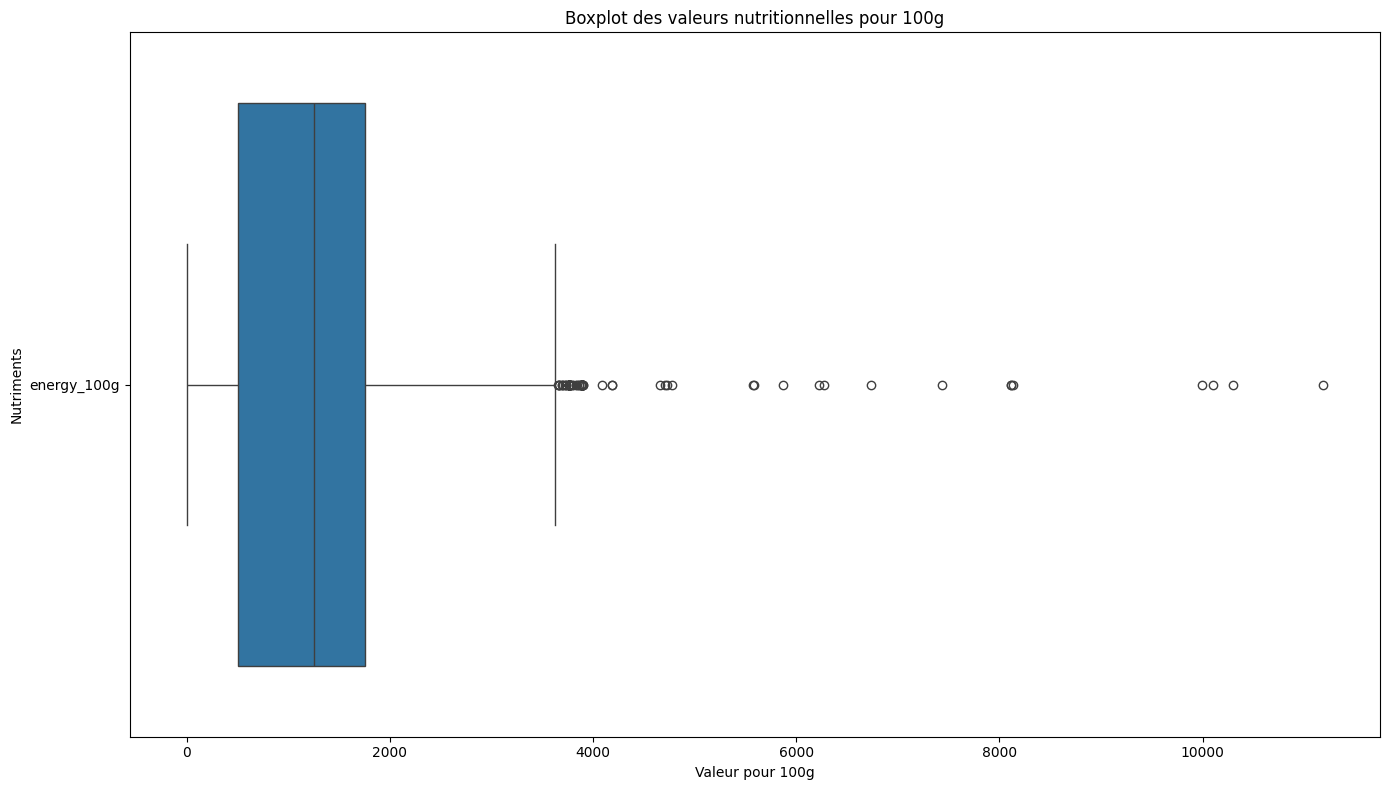

In [34]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_output_100g[col_energy], orient='h')
plt.title('Boxplot des valeurs nutritionnelles pour 100g')
plt.xlabel('Valeur pour 100g')
plt.ylabel('Nutriments')

# Afficher le graphique
plt.tight_layout()
plt.show()

In [35]:
# Calcul des quantiles pour la colonne 'energy-kcal_100g'
Q1 = df_output_100g[col_energy].quantile(0.25)
Q3 = df_output_100g[col_energy].quantile(0.75)

# Calcul de l'écart interquartile (IQR)
IQR = Q3 - Q1

# Définition des bornes inférieure et supérieure pour détecter les valeurs aberrantes
borne_inferieure = Q1 - 1.5 * IQR
borne_superieure = Q3 + 1.5 * IQR

# Filtrage des valeurs non aberrantes dans 'energy-kcal_100g' en gardant les valeurs dans les bornes
valeurs_non_aberrantes_100g = df_output_100g.copy()
valeurs_non_aberrantes_100g.loc[:, col_energy] = valeurs_non_aberrantes_100g.where((df_output_100g[col_energy] >= borne_inferieure) & (df_output_100g[col_energy] <= borne_superieure))
valeurs_non_aberrantes_100g.dropna(subset=col_nutri)

# Affichage de la plage des valeurs retenues
print(f"Borne inférieure : {borne_inferieure}, Borne supérieure : {borne_superieure}")
print(f"Nombre de lignes après filtrage des valeurs aberrantes : {valeurs_non_aberrantes_100g.shape[0]}")


Borne inférieure : energy_100g   -1370.5
dtype: float64, Borne supérieure : energy_100g    3633.5
dtype: float64
Nombre de lignes après filtrage des valeurs aberrantes : 183567


In [36]:
valeurs_non_aberrantes_100g.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
count,183465.000000,183567.000000,183567.000000,183567.000000,183567.000000,183567.000000,183567.000000,183567.000000,183567.000000,183567.000000,183567.000000,183567.000000,183567.000000,183567.000000
mean,1204.386511,13.364628,4.747815,0.036752,0.033608,35.088520,14.935859,2.830153,8.100889,1.323259,0.529319,0.117370,0.003137,20.579345
std,731.437057,15.106614,6.831102,0.640894,1.030708,28.017381,18.982915,4.322379,8.534691,13.397484,5.358062,2.578441,0.174538,32.130243
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.878101
25%,506.000000,1.110000,0.000000,0.000000,0.000000,9.170000,1.600000,0.000000,2.500000,0.150000,0.060000,0.000000,0.000000,0.000000
50%,1255.000000,8.330000,1.790000,0.000000,0.000000,28.350000,5.560000,1.500000,6.000000,0.735000,0.294000,0.036000,0.001000,1.805000
75%,1753.000000,21.430000,7.140000,0.000000,0.021000,60.000000,23.750000,3.600000,11.110000,1.402500,0.561000,0.100000,0.002400,25.032347
max,3630.000000,225.000000,121.000000,130.000000,116.915000,1750.000000,133.000000,100.000000,800.000000,3330.000000,1330.000000,500.000000,69.000000,1800.098419


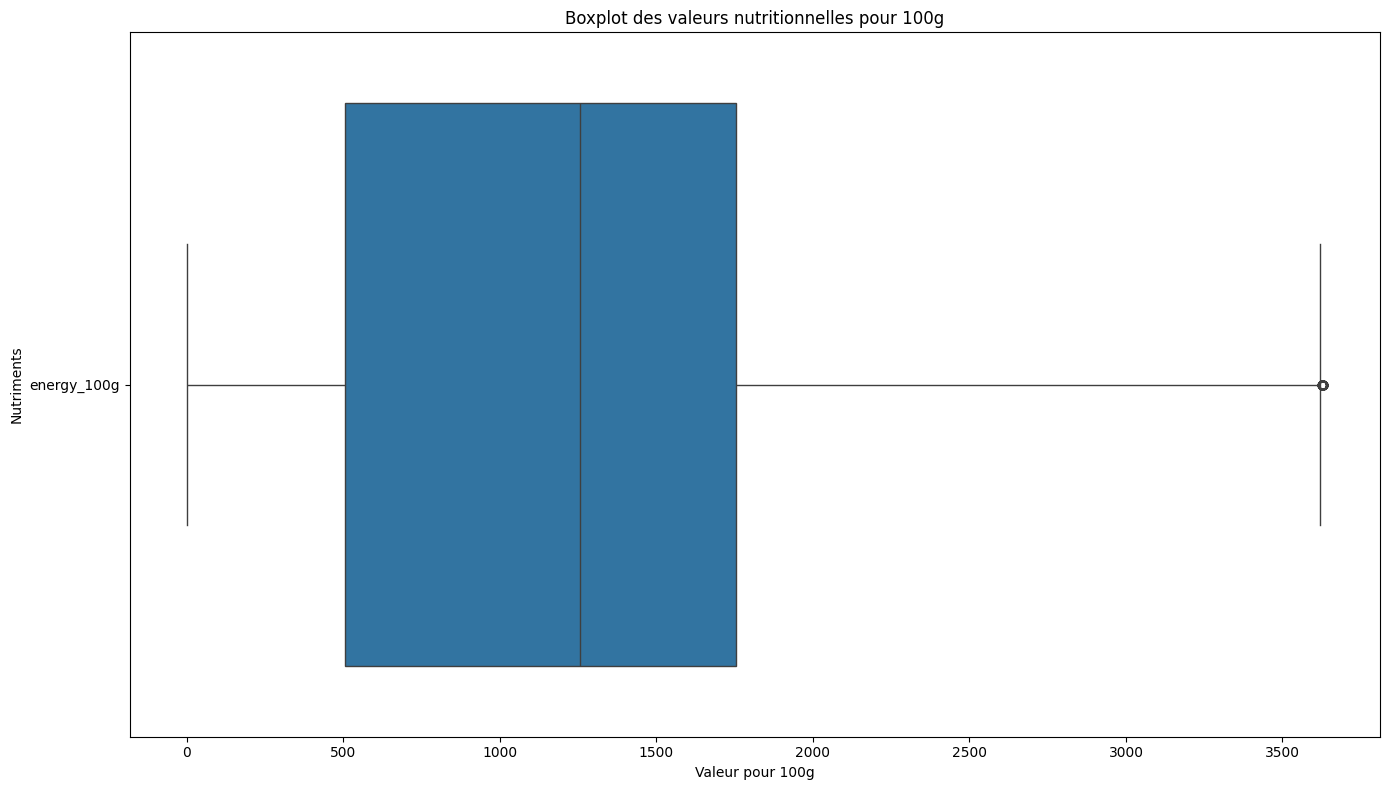

In [37]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=valeurs_non_aberrantes_100g[col_energy], orient='h')
plt.title('Boxplot des valeurs nutritionnelles pour 100g')
plt.xlabel('Valeur pour 100g')
plt.ylabel('Nutriments')

# Afficher le graphique
plt.tight_layout()
plt.show()

#### 2. Colonne nutrition

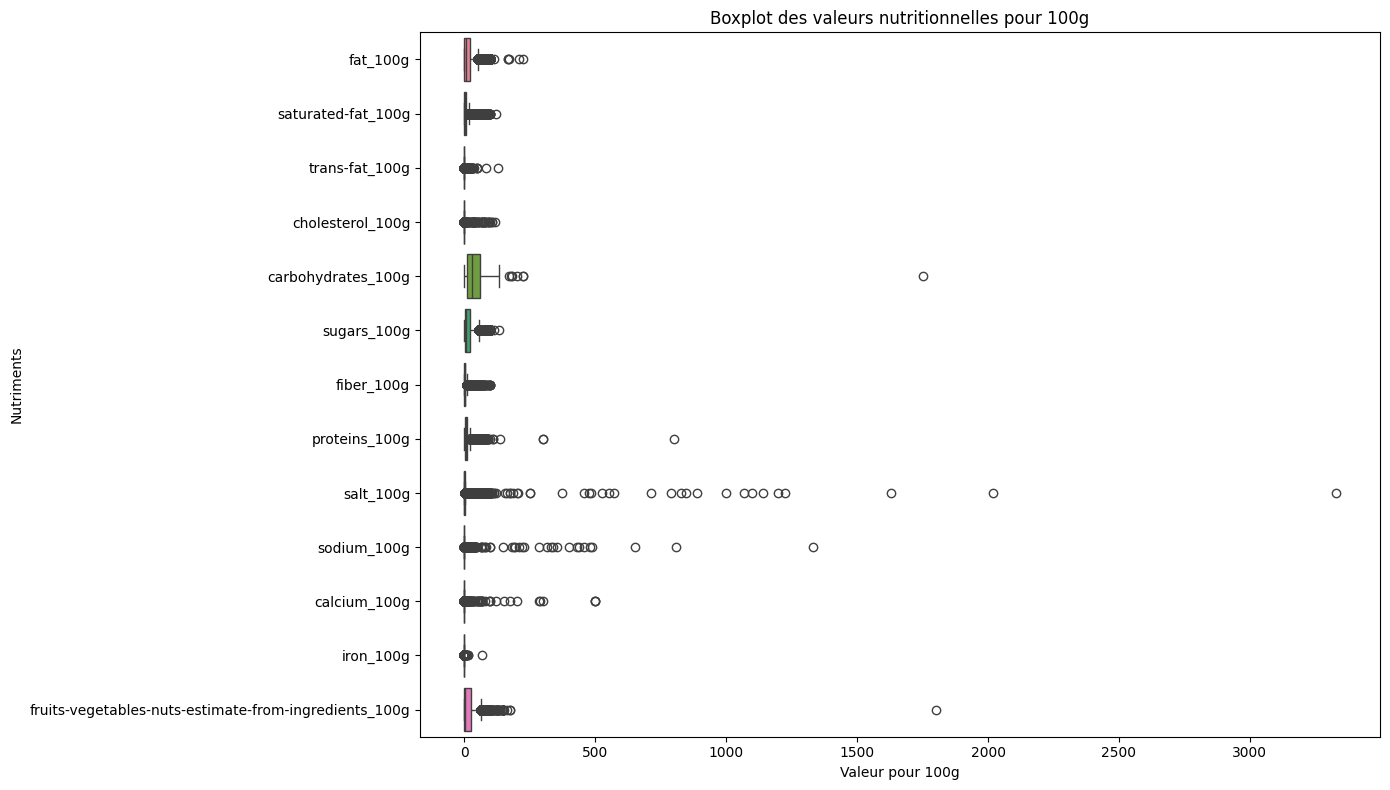

In [38]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=valeurs_non_aberrantes_100g[col_nutri], orient='h')
plt.title('Boxplot des valeurs nutritionnelles pour 100g')
plt.xlabel('Valeur pour 100g')
plt.ylabel('Nutriments')

# Afficher le graphique
plt.tight_layout()
plt.show()

In [39]:
valeurs_non_aberrantes_100g.loc[:, col_nutri] = valeurs_non_aberrantes_100g[col_nutri].where((valeurs_non_aberrantes_100g[col_nutri] >= 0) & (valeurs_non_aberrantes_100g[col_nutri] <= 100))
valeurs_non_aberrantes_100g = valeurs_non_aberrantes_100g.dropna(subset=col_nutri)


In [40]:
valeurs_non_aberrantes_100g.describe()

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
count,183346.000000,183440.000000,183440.000000,183440.000000,183440.000000,183440.000000,183440.000000,183440.000000,183440.000000,183440.000000,183440.000000,183440.000000,183440.000000,183440.000000
mean,1204.482142,13.360686,4.745819,0.036052,0.031070,35.077588,14.937299,2.829253,8.090895,1.192966,0.477185,0.100823,0.003075,20.550406
std,731.405256,15.077746,6.816014,0.564751,0.903842,27.711340,18.979838,4.317944,8.259119,3.382110,1.352838,0.762463,0.174169,31.823558
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,506.000000,1.110000,0.000000,0.000000,0.000000,9.170000,1.600000,0.000000,2.500000,0.150000,0.060000,0.000000,0.000000,0.000000
50%,1255.000000,8.330000,1.790000,0.000000,0.000000,28.360000,5.560000,1.500000,6.000000,0.735000,0.294000,0.036000,0.001000,1.804940
75%,1753.000000,21.430000,7.140000,0.000000,0.021000,60.000000,23.750000,3.600000,11.110000,1.402500,0.561000,0.100000,0.002400,25.000635
max,3630.000000,100.000000,100.000000,83.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,69.000000,100.000000


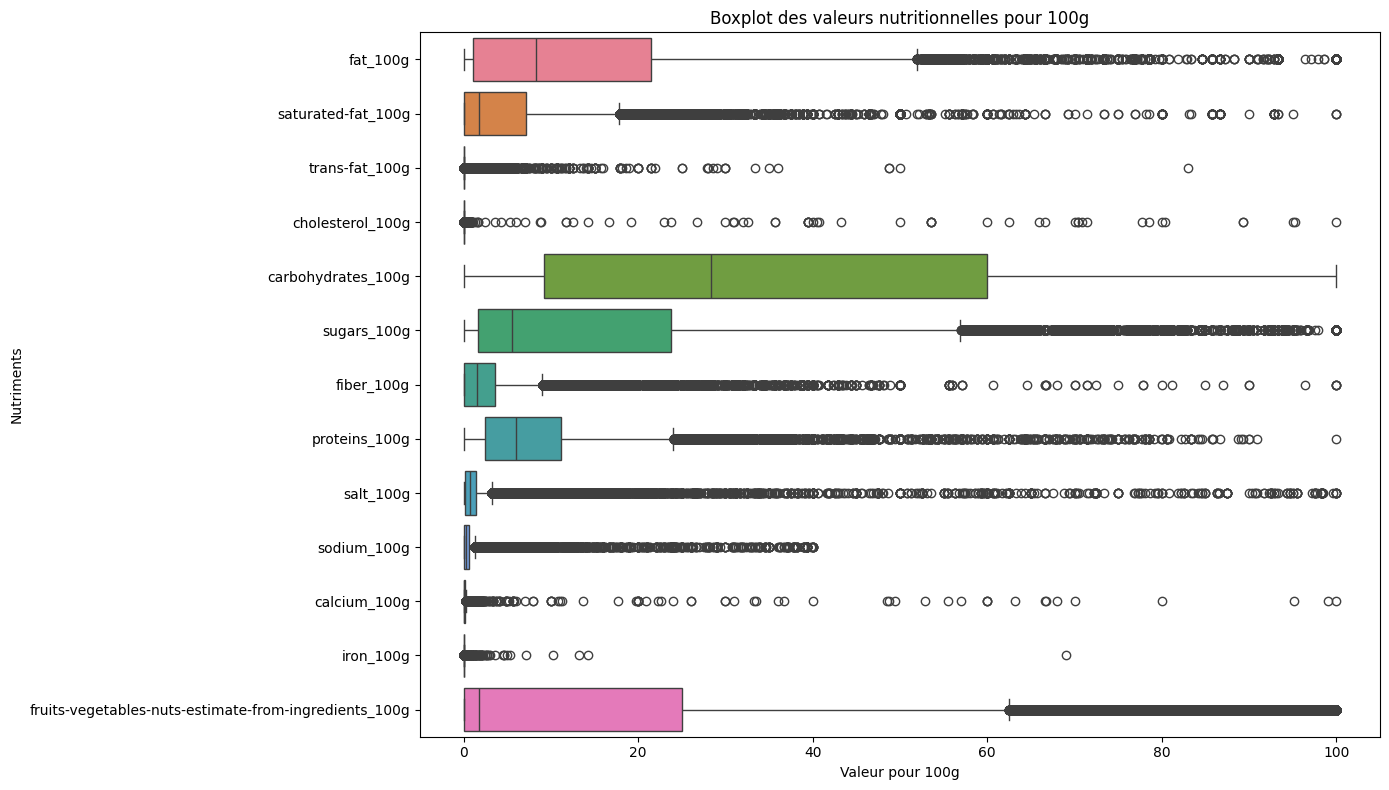

In [41]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=valeurs_non_aberrantes_100g[col_nutri], orient='h')
plt.title('Boxplot des valeurs nutritionnelles pour 100g')
plt.xlabel('Valeur pour 100g')
plt.ylabel('Nutriments')

# Afficher le graphique
plt.tight_layout()
plt.show()

In [42]:
# Somme totale de tous les nutriments
COL_SUM_NUTRI = "somme_nutriments"
valeurs_non_aberrantes_100g[COL_SUM_NUTRI] = valeurs_non_aberrantes_100g[col_nutri].sum(axis=1)

valeurs_non_aberrantes_100g.loc[:, COL_SUM_NUTRI] = valeurs_non_aberrantes_100g[COL_SUM_NUTRI].where((valeurs_non_aberrantes_100g[COL_SUM_NUTRI] >= 0) & (valeurs_non_aberrantes_100g[COL_SUM_NUTRI] <= 100))
valeurs_non_aberrantes_100g = valeurs_non_aberrantes_100g.dropna(subset=COL_SUM_NUTRI)
valeurs_non_aberrantes_100g

,energy_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,somme_nutriments
165662,695.0,7.14,4.760,0.0,0.02380,4.76,4.76,0.00,9.52,2.30000,0.919000,0.38100,0.000000e+00,0.976562,35.540362
390786,944.0,8.27,3.760,0.0,0.02260,27.80,3.76,1.50,9.77,1.36000,0.542000,0.18800,8.120000e-04,4.166667,61.140079
355370,889.0,12.50,2.500,0.0,0.01870,0.00,0.00,0.00,26.20,0.73000,0.292000,0.05000,9.000000e-04,12.682500,54.974100
2130951,1423.0,1.00,0.200,0.0,0.00000,72.00,1.60,3.50,10.00,0.00762,0.003048,0.00018,2.160000e-07,0.000000,88.310848
990938,1080.0,15.70,0.714,0.0,0.00000,25.70,0.00,2.86,2.86,0.98000,0.392000,0.00000,1.030000e-03,14.215000,63.422030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98028,134.0,2.00,1.800,0.0,0.00000,3.20,2.80,0.00,0.00,0.03000,0.012000,0.30000,3.600000e-04,0.000000,10.142360
778838,1570.0,6.25,1.250,0.0,0.00000,67.50,0.00,10.00,12.50,0.00000,0.000000,0.00000,4.000000e-03,0.000000,97.504000
481122,1550.0,4.29,2.860,0.0,0.11400,11.40,2.86,2.86,71.40,1.21000,0.486000,0.37100,3.140000e-03,0.000000,97.854140
2158617,1200.0,3.23,1.610,0.0,0.00161,50.00,6.45,4.84,14.50,0.90700,0.363000,0.16100,4.940000e-03,0.000000,82.067550


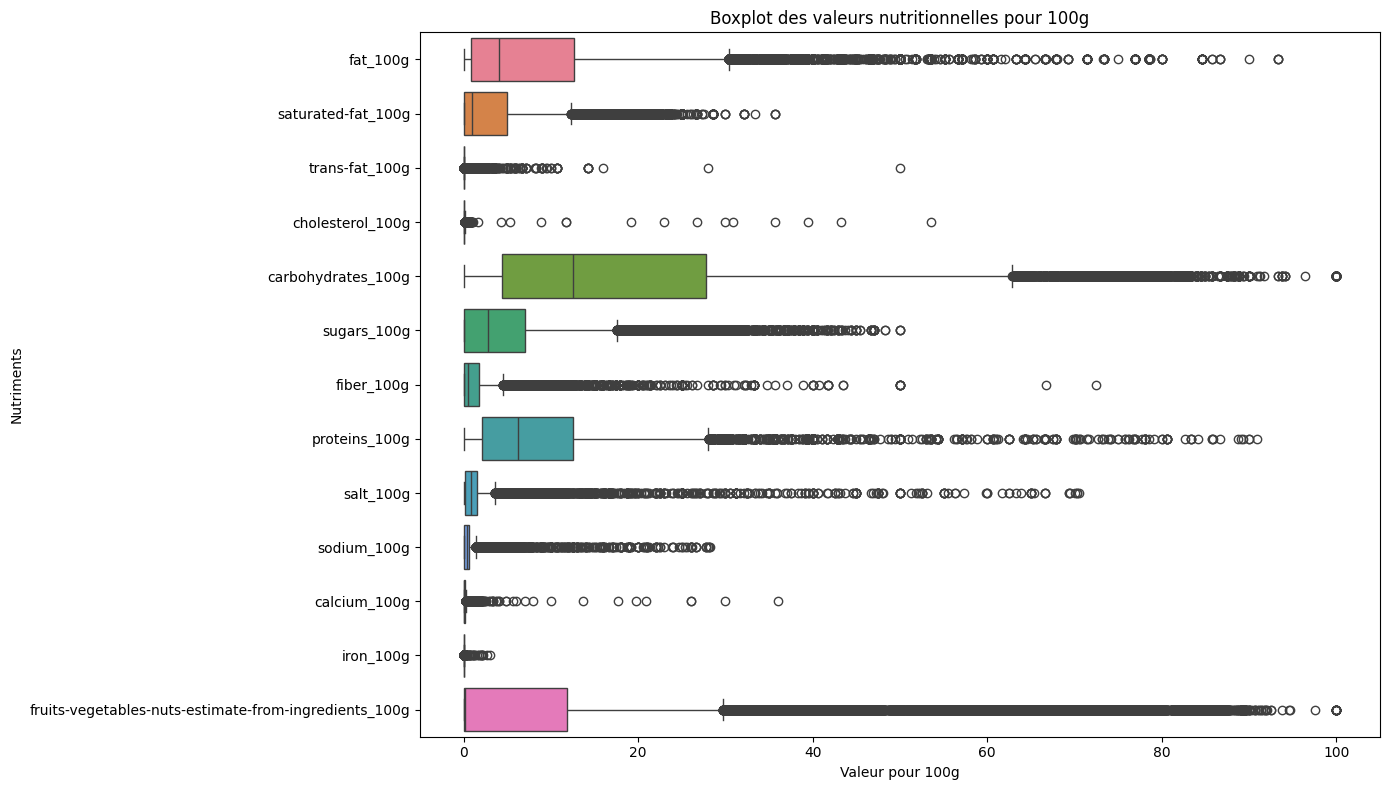

In [43]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=valeurs_non_aberrantes_100g[col_nutri], orient='h')
plt.title('Boxplot des valeurs nutritionnelles pour 100g')
plt.xlabel('Valeur pour 100g')
plt.ylabel('Nutriments')

# Afficher le graphique
plt.tight_layout()
plt.show()

#### 3. Application des calcules valeur manquantes et aberrante

In [44]:
df_output_clean = df_output
# VALEUR MANQUANTE
df_output_clean = df_output_clean.dropna(subset = column_100g)

# VALEUR ABERRANTE
# Calcul des quantiles pour la colonne 'energy-kcal_100g'
Q1 = df_output_clean[col_energy].quantile(0.25)
Q3 = df_output_clean[col_energy].quantile(0.75)

# Calcul de l'écart interquartile (IQR)
IQR = Q3 - Q1

# Définition des bornes inférieure et supérieure pour détecter les valeurs aberrantes
borne_inferieure = Q1 - 1.5 * IQR
borne_superieure = Q3 + 1.5 * IQR

# Filtrage des valeurs non aberrantes dans 'energy-kcal_100g' en gardant les valeurs dans les bornes
df_output_clean.loc[:, col_energy] = df_output_clean.where((df_output_clean[col_energy] >= borne_inferieure) & (df_output_clean[col_energy] <= borne_superieure))
df_output_clean.dropna(subset=col_nutri)


df_output_clean.loc[:, col_nutri] = df_output_clean[col_nutri].where((df_output_clean[col_nutri] >= 0) & (df_output_clean[col_nutri] <= 100))
df_output_clean = df_output_clean.dropna(subset=col_nutri)
df_output_clean[COL_SUM_NUTRI] = df_output_clean[col_nutri].sum(axis=1)

df_output_clean.loc[:, COL_SUM_NUTRI] = df_output_clean[COL_SUM_NUTRI].where((df_output_clean[COL_SUM_NUTRI] >= 0) & (df_output_clean[COL_SUM_NUTRI] <= 100))
df_output_clean = df_output_clean.dropna(subset=COL_SUM_NUTRI)


# 6. Sélection des colonnes pertinentes

## a. Colonnes pertinentes des valeurs explicatives

In [45]:
df_output_clean.describe()

,created_t,last_modified_t,last_updated_t,nova_group,ecoscore_score,product_quantity,unique_scans_n,completeness,last_image_t,energy_100g,...,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,calcium_100g,iron_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,somme_nutriments
count,9.338500e+04,9.338500e+04,9.338500e+04,90479.000000,27013.000000,8148.000000,10329.000000,93385.000000,1.976000e+04,93380.000000,...,93385.000000,93385.000000,93385.000000,93385.000000,93385.000000,93385.000000,93385.000000,93385.000000,93385.000000,93385.000000
mean,1.532908e+09,1.615544e+09,1.710722e+09,3.504692,47.052271,585.697338,1.540904,0.495102,1.646640e+09,796.074602,...,19.501680,5.401793,1.301143,8.472773,1.194731,0.477891,0.112728,0.001473,11.112675,59.881067
std,5.249555e+07,4.779933e+07,6.557020e+06,0.884745,20.304742,4490.040119,1.870336,0.093534,4.978132e+07,519.111641,...,20.146005,7.172822,2.193443,8.387808,2.316179,0.926461,0.311070,0.025118,20.759667,25.543599
min,1.338328e+09,1.439142e+09,1.707490e+09,1.000000,-20.000000,0.000000,1.000000,0.300000,1.340843e+09,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.489071e+09,1.587592e+09,1.707506e+09,3.000000,34.000000,226.796185,1.000000,0.400000,1.627086e+09,343.000000,...,4.420000,0.000000,0.000000,2.140000,0.176923,0.070700,0.000000,0.000000,0.000000,39.242585
50%,1.489139e+09,1.587647e+09,1.707652e+09,4.000000,36.000000,398.000000,1.000000,0.500000,1.651300e+09,749.000000,...,12.500000,2.780000,0.532000,6.250000,0.865000,0.346000,0.036000,0.000570,0.130156,62.711486
75%,1.587659e+09,1.644527e+09,1.707766e+09,4.000000,67.000000,568.000000,1.000000,0.500000,1.675341e+09,1188.000000,...,27.780000,7.020000,1.800000,12.500000,1.550000,0.620000,0.117000,0.001420,11.878986,81.497500
max,1.729450e+09,1.729481e+09,1.729481e+09,4.000000,118.000000,400000.000000,68.000000,1.100000,1.729470e+09,3628.000000,...,100.000000,50.000000,72.500000,90.910000,70.455000,28.182000,36.000000,3.000000,100.000000,100.000000


In [46]:
# Obtenir le maximum de chaque colonne
max_values = df_output[col_nutri].describe().loc['max']

# Filtrer pour obtenir les colonnes dont le max n'est pas 0
COL_NUTRI_USEFUL = max_values[max_values != 0].index.tolist() + ["energy_100g"]

COL_NUTRI_USEFUL 

['fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'calcium_100g',
 'iron_100g',
 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
 'energy_100g']

## b. Colonne pertinentes des valeurs affichages

In [47]:
SELECTED_COLS = [
  "code",
  "url",
  "product_name",
  "quantity",
  "brands",
  "categories",
  "countries_en",
  "nutriscore_score",
  "nutriscore_grade",
  "image_url",
  "pnns_groups_1",
  "pnns_groups_2"
  ]

# 7. Génération du fichier nettoyé

In [48]:
COL_PERTINENTES = SELECTED_COLS + COL_NUTRI_USEFUL
COL_PERTINENTES

['code',
 'url',
 'product_name',
 'quantity',
 'brands',
 'categories',
 'countries_en',
 'nutriscore_score',
 'nutriscore_grade',
 'image_url',
 'pnns_groups_1',
 'pnns_groups_2',
 'fat_100g',
 'saturated-fat_100g',
 'trans-fat_100g',
 'cholesterol_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'calcium_100g',
 'iron_100g',
 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
 'energy_100g']

On vérifie qu'il y a bien toutes les valeurs cibles

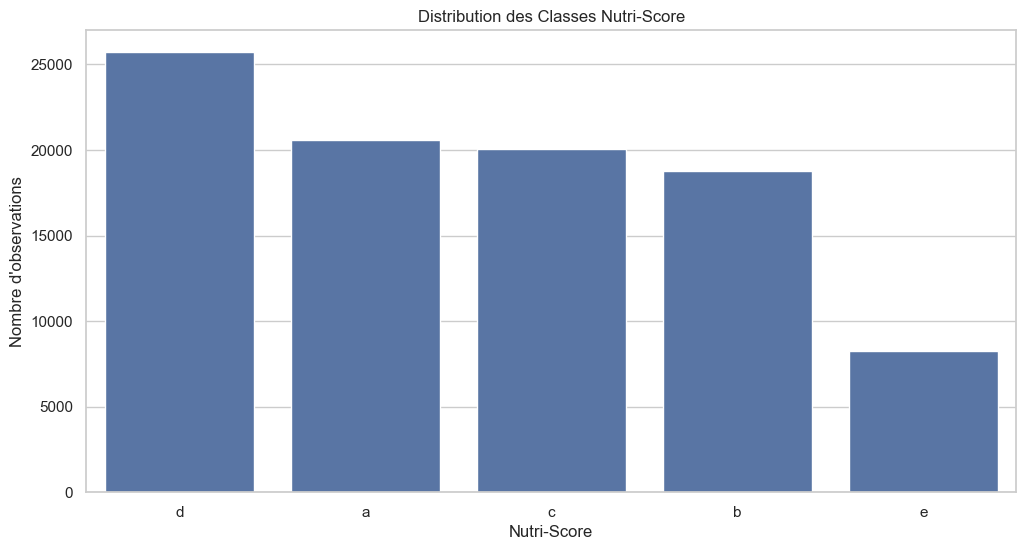

In [49]:
# Configurer le style de Seaborn
sns.set(style="whitegrid")

# Créer une figure pour les visualisations
plt.figure(figsize=(12, 6))

# Graphique de distribution du Nutri-Score
sns.countplot(x='nutriscore_grade', data=df_output_clean, order=df_output_clean['nutriscore_grade'].value_counts().index)
plt.title('Distribution des Classes Nutri-Score')
plt.xlabel('Nutri-Score')
plt.ylabel('Nombre d\'observations')
plt.show()

In [50]:
df_output_clean = df_output_clean.dropna(subset=["energy_100g"], axis=0)

# Exporter en CSV avec un séparateur de tabulation (\t)
df_output_clean[COL_PERTINENTES].to_csv(OUTPUT_PATH, sep='\t', index=False)

# 8. Entrainement de données

In [51]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

FILE_PATH = "en.openfoodfacts.org.products.csv"

CHUNK_SIZE = 10000
NUTRISCORE_GRADE =  ["a", "b", "c", "d", "e"]
COLS_TARGET = ['nutriscore_grade']
SEUIL_VALEURS_VIDES=20
OUTPUT_PATH = "dataset/openfoodfact_clean.csv"
OUTPUT_AFTER_CHUNK_PATH = "dataset/openfoodfact_after_chunk.csv"
UNKNOWN_COUTRY = "unknown"
COL_FOR_COUNTRY = "countries_en"



df_output = pd.read_csv(OUTPUT_PATH, sep="\t", low_memory=False, header=0, on_bad_lines="skip")

## a. Choix du modèles

Étant donné que la variable cible est non numérique, nous opterons pour un modèle de classification et sélectionnerons celui offrant les meilleures performances :
- Regression logistique 
- Random Forest
- SVC
- KNeighbors
- GradientBoosting
- HistGradientBoosting

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

FEATURES_COL = [col for col in df_output.columns if "_100g" in col or col in ['pnns_groups_1']] 

features = df_output[FEATURES_COL].copy()
features['pnns_groups_1'] = LabelEncoder().fit_transform(features['pnns_groups_1'])
target = df_output[COLS_TARGET].copy()

features_train, feature_test, target_train, target_test = train_test_split(features, target, random_state=42, test_size=0.2)

### 1. Regression logistique

La régression logistique est un modèle statistique utilisé pour prédire la probabilité d'appartenance à une classe binaire ou catégorielle, en fonction de variables explicatives.

c:\Users\Utilisateur\OneDrive\Documents\Simplon\Brief\11_OpenFoodFacts\SandBox\.venv\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Utilisateur\OneDrive\Documents\Simplon\Brief\11_OpenFoodFacts\SandBox\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score       support
a              0.545191  0.786154  0.643866   4059.000000
b              0.458640  0.147874  0.223642   3787.000000
c              0.398793  0.364046  0.380628   3994.000000
d              0.544627  0.789678  0.644650   5154.000000
e              0.472050  0.135553  0.210624   1682.000000
accuracy       0.508835  0.508835  0.508835      0.508835
macro avg      0.483860  0.444661  0.420682  18676.000000
weighted avg   0.489590  0.508835  0.463558  18676.000000


<Figure size 1000x700 with 0 Axes>

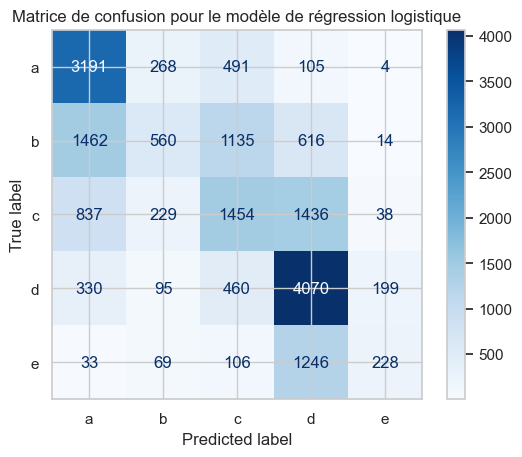

In [53]:
from sklearn.linear_model import LogisticRegression

# Initialisation et entraînement du modèle de régression logistique
logistic_model = LogisticRegression(max_iter=100, random_state=42)
logistic_model.fit(features_train, target_train)

# Prédictions sur les données de test
target_prediction_logistic = logistic_model.predict(feature_test)

# Évaluation des performances du modèle
logistic_report = classification_report(target_test, target_prediction_logistic, output_dict=True)
logistic_df = pd.DataFrame(logistic_report).transpose()
print(logistic_df)

# Visualisation de la matrice de confusion pour le modèle de régression logistique
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay.from_estimator(logistic_model, feature_test, target_test, cmap='Blues')
plt.title('Matrice de confusion pour le modèle de régression logistique')
plt.show()



Pour la régression logistique, la précision est à **67%**

### 2. Random Forest

La forêt aléatoire est un modèle d'apprentissage supervisé qui combine plusieurs arbres de décision pour améliorer la précision des prédictions et réduire le risque de surapprentissage.

c:\Users\Utilisateur\OneDrive\Documents\Simplon\Brief\11_OpenFoodFacts\SandBox\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score       support
a              0.969085  0.957625  0.963321   4059.000000
b              0.916645  0.923422  0.920021   3787.000000
c              0.919546  0.932899  0.926174   3994.000000
d              0.958615  0.961777  0.960194   5154.000000
e              0.965581  0.934007  0.949532   1682.000000
accuracy       0.944421  0.944421  0.944421      0.944421
macro avg      0.945894  0.941946  0.943848  18676.000000
weighted avg   0.944652  0.944421  0.944492  18676.000000


<Figure size 1000x700 with 0 Axes>

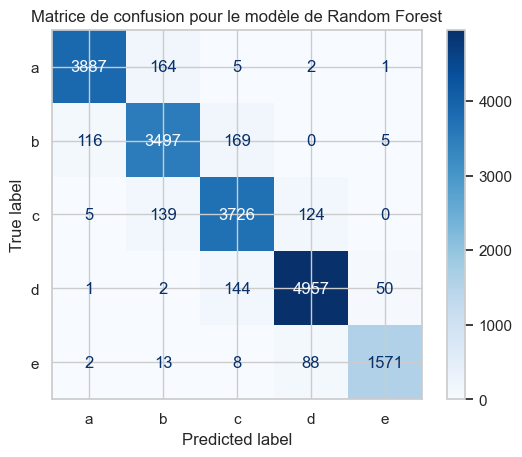

In [54]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)

# Entraînement des modèles
rf_model.fit(features_train, target_train)
target_prediction_rf = rf_model.predict(feature_test)

# Évaluation des performances des modèles
rf_report = classification_report(target_test, target_prediction_rf, output_dict=True)

rf_df = pd.DataFrame(rf_report).transpose()
print(rf_df)
# Visualisation de la matrice de confusion pour le modèle de régression logistique
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay.from_estimator(rf_model, feature_test, target_test, cmap='Blues')
plt.title('Matrice de confusion pour le modèle de Random Forest')
plt.show()


Pour random forest, la précision est à **94.0553%**

### 3. SVC

Le SVC (Support Vector Classifier) est un modèle d'apprentissage supervisé basé sur les machines à vecteurs de support, qui cherche à séparer les classes en maximisant la marge entre elles pour une meilleure précision de classification.

c:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LibSVM]

c:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score      support
a              0.378632  0.621857  0.470680  1949.000000
b              0.209349  0.226832  0.217740  1856.000000
c              0.377604  0.223650  0.280917  1945.000000
d              0.600456  0.493079  0.541495  2673.000000
e              0.157514  0.131643  0.143421   828.000000
accuracy       0.377797  0.377797  0.377797     0.377797
macro avg      0.344711  0.339412  0.330851  9251.000000
weighted avg   0.388756  0.377797  0.371207  9251.000000


<Figure size 1000x700 with 0 Axes>

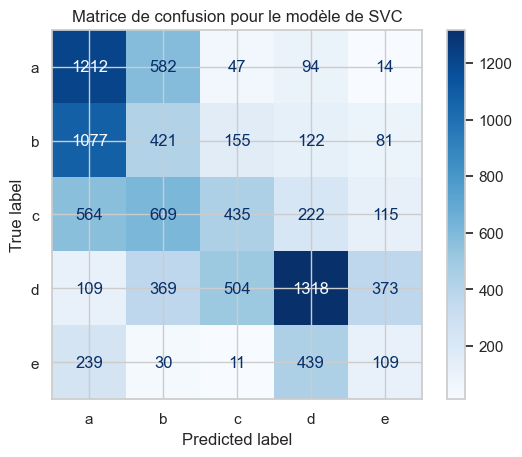

In [300]:
from sklearn.svm import SVC


svc_model = SVC(kernel="linear", max_iter=20000, random_state=42, verbose=True)

# Entraînement des modèles
svc_model.fit(features_train, target_train)
target_prediction_svc = svc_model.predict(feature_test)

# Évaluation des performances des modèles
svc_report = classification_report(target_test, target_prediction_svc, output_dict=True)

svc_df = pd.DataFrame(svc_report).transpose()
print(svc_df)

# Visualisation de la matrice de confusion pour le modèle de régression logistique
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay.from_estimator(svc_model, feature_test, target_test, cmap='Blues')
plt.title('Matrice de confusion pour le modèle de SVC')
plt.show()

Pour le SVC, la précision est à **38.7051%**

### 4. KNeighbors

Le K-Neighbors (ou K-Nearest Neighbors, KNN) est un algorithme de classification basé sur la proximité, qui prédit la classe d'un échantillon en fonction des classes des "K" échantillons les plus proches dans l'espace des caractéristiques.

c:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score      support
a              0.706888  0.721396  0.714068  1949.000000
b              0.544025  0.559267  0.551541  1856.000000
c              0.577657  0.544987  0.560847  1945.000000
d              0.755182  0.790498  0.772436  2673.000000
e              0.769764  0.670290  0.716591   828.000000
accuracy       0.667171  0.667171  0.667171     0.667171
macro avg      0.670703  0.657287  0.663097  9251.000000
weighted avg   0.666625  0.667171  0.666337  9251.000000


<Figure size 1000x700 with 0 Axes>

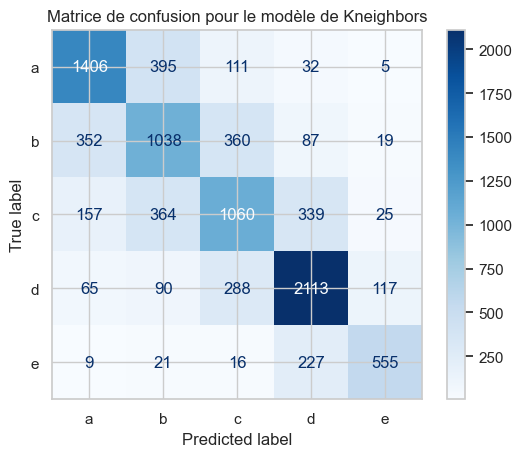

In [303]:
from sklearn.neighbors import KNeighborsClassifier

k_model = KNeighborsClassifier(n_neighbors=50)

# Entraînement des modèles
k_model.fit(features_train, target_train)
target_prediction_k = k_model.predict(feature_test)

# Évaluation des performances des modèles
k_report = classification_report(target_test, target_prediction_k, output_dict=True)

k_df = pd.DataFrame(k_report).transpose()
print(k_df)

# Visualisation de la matrice de confusion pour le modèle de régression logistique
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay.from_estimator(k_model, feature_test, target_test, cmap='Blues')
plt.title('Matrice de confusion pour le modèle de Kneighbors')
plt.show()

Pour Kneighbors, la précision est à **80%**

### 5. GradientBoosting

Le Gradient Boosting est un modèle d'apprentissage supervisé qui combine plusieurs modèles faibles (souvent des arbres de décision) en séquence, chaque modèle corrigeant les erreurs des précédents, pour améliorer la précision globale de la prédiction.

c:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score      support
a              0.933265  0.919110  0.926133  1978.000000
b              0.787342  0.850191  0.817560  1829.000000
c              0.854045  0.790504  0.821047  2043.000000
d              0.902137  0.927525  0.914655  2594.000000
e              0.896239  0.855198  0.875237   808.000000
accuracy       0.873865  0.873865  0.873865     0.873865
macro avg      0.874606  0.868506  0.870927  9252.000000
weighted avg   0.874964  0.873865  0.873802  9252.000000


<Figure size 1000x700 with 0 Axes>

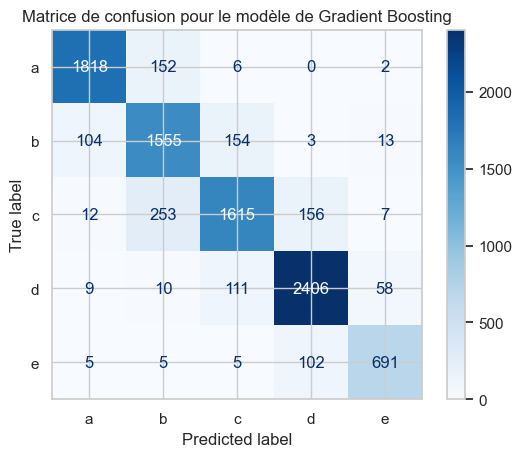

In [173]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)

# Entraînement des modèles
gb_model.fit(features_train, target_train)
target_prediction_gb = gb_model.predict(feature_test)

# Évaluation des performances des modèles
gb_report = classification_report(target_test, target_prediction_gb, output_dict=True)

gb_df = pd.DataFrame(gb_report).transpose()
print(gb_df)

# Visualisation de la matrice de confusion pour le modèle de régression logistique
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay.from_estimator(gb_model, feature_test, target_test, cmap='Blues')
plt.title('Matrice de confusion pour le modèle de Gradient Boosting')
plt.show()

### 6. HistGradientBoosting

Le HistGradientBoosting est une version optimisée du Gradient Boosting qui utilise des histogrammes pour réduire les calculs, offrant ainsi une meilleure performance sur de grands ensembles de données.

c:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score     support
a              0.985316  0.983822  0.984569  1978.00000
b              0.951630  0.957354  0.954484  1829.00000
c              0.956607  0.949584  0.953083  2043.00000
d              0.974280  0.978412  0.976342  2594.00000
e              0.962687  0.957921  0.960298   808.00000
accuracy       0.967250  0.967250  0.967250     0.96725
macro avg      0.966104  0.965418  0.965755  9252.00000
weighted avg   0.967247  0.967250  0.967242  9252.00000


<Figure size 1000x700 with 0 Axes>

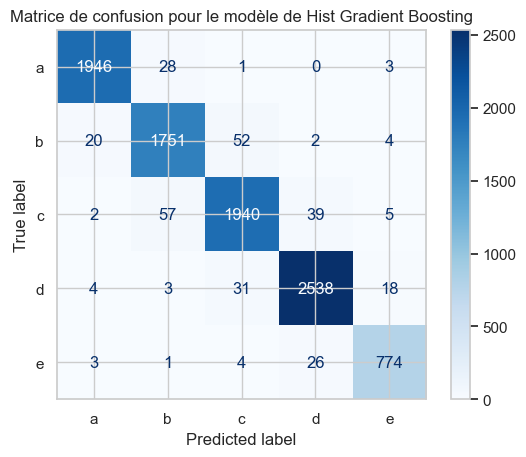

In [252]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_model = HistGradientBoostingClassifier(
    max_iter=100,           # Nombre d'itérations (arbres)
    max_depth=10,           # Profondeur maximale des arbres
    learning_rate=0.1,      # Taux d'apprentissage
    random_state=42
)

# Entraînement des modèles
hgb_model.fit(features_train, target_train)
target_prediction_hgb = hgb_model.predict(feature_test)

# Évaluation des performances des modèles
hgb_report = classification_report(target_test, target_prediction_hgb, output_dict=True)

hgb_df = pd.DataFrame(hgb_report).transpose()
print(hgb_df)

# Visualisation de la matrice de confusion pour le modèle de régression logistique
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay.from_estimator(hgb_model, feature_test, target_test, cmap='Blues')
plt.title('Matrice de confusion pour le modèle de Hist Gradient Boosting')
plt.show()

En analysant chaque modèle, on observe que **RandomForest** est le plus **optimal** en termes de **précision** et de **temps d'exécution**.

## 2. Choix du Préprocessing

### a. PNNS_GROUP_1

#### 1. LabelEncoder

In [174]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

FEATURES_COL = [col for col in df_output.columns if "_100g" in col or col in ['pnns_groups_1']] 

features = df_output[FEATURES_COL].copy()
features['pnns_groups_1'] = LabelEncoder().fit_transform(features['pnns_groups_1'])
target = df_output[COLS_TARGET].copy()

features_train, feature_test, target_train, target_test = train_test_split(features, target, random_state=42, test_size=0.1)

rf_model = RandomForestClassifier(random_state=42)

# Entraînement des modèles
rf_model.fit(features_train, target_train)
target_prediction_rf = rf_model.predict(feature_test)

# Évaluation des performances des modèles
rf_report = classification_report(target_test, target_prediction_rf, output_dict=True)

rf_df_label = pd.DataFrame(rf_report).transpose()

rf_df_label

c:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,precision,recall,f1-score,support
a,0.966480,0.962083,0.964277,1978.000000
b,0.908599,0.918535,0.913540,1829.000000
c,0.923343,0.913852,0.918573,2043.000000
d,0.950322,0.966076,0.958134,2594.000000
e,0.962581,0.923267,0.942514,808.000000
accuracy,0.940553,0.940553,0.940553,0.940553
macro avg,0.942265,0.936763,0.939408,9252.000000
weighted avg,0.940642,0.940553,0.940532,9252.000000


#### 2. OneHot

In [175]:
from sklearn.ensemble import RandomForestClassifier

FEATURES_COL = [col for col in df_output.columns if "_100g" in col] 

features = df_output[FEATURES_COL].copy()
dummies = pd.get_dummies(df_output['pnns_groups_1'], prefix='pnns_groups_1')
# Ajouter les colonnes encodées au DataFrame initial
features = pd.concat([features, dummies], axis=1)
target = df_output[COLS_TARGET].copy()

features_train, feature_test, target_train, target_test = train_test_split(features, target, random_state=42, test_size=0.1)

rf_model = RandomForestClassifier(random_state=42)

# Entraînement des modèles
rf_model.fit(features_train, target_train)
target_prediction_rf = rf_model.predict(feature_test)

# Évaluation des performances des modèles
rf_report = classification_report(target_test, target_prediction_rf, output_dict=True)

rf_df_onehot = pd.DataFrame(rf_report).transpose()

rf_df_onehot

c:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,precision,recall,f1-score,support
a,0.960406,0.956522,0.958460,1978.000000
b,0.904348,0.909787,0.907059,1829.000000
c,0.918057,0.915810,0.916932,2043.000000
d,0.952780,0.964534,0.958621,2594.000000
e,0.961440,0.925743,0.943253,808.000000
accuracy,0.937851,0.937851,0.937851,0.937851
macro avg,0.939406,0.934479,0.936865,9252.000000
weighted avg,0.937925,0.937851,0.937846,9252.000000


#### 3. Ordinal

In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

# Sélection des colonnes explicatives
FEATURES_COL = [col for col in df_output.columns if "_100g" in col  or col in ['pnns_groups_1']] 

# Copie des caractéristiques
features = df_output[FEATURES_COL].copy()

# Encodage ordinal de 'pnns_groups_1'
ordinal_encoder = OrdinalEncoder()
features['pnns_groups_1'] = ordinal_encoder.fit_transform(features[['pnns_groups_1']])

# Définition de la cible
target = df_output[COLS_TARGET].copy()

# Séparation des données d'entraînement et de test
features_train, feature_test, target_train, target_test = train_test_split(features, target, random_state=42, test_size=0.1)

# Initialisation et entraînement du modèle RandomForest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(features_train, target_train)

# Prédictions et évaluation des performances
target_prediction_rf = rf_model.predict(feature_test)
rf_report = classification_report(target_test, target_prediction_rf, output_dict=True)
rf_df_ordinal = pd.DataFrame(rf_report).transpose()

rf_df_ordinal

c:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,precision,recall,f1-score,support
a,0.966480,0.962083,0.964277,1978.000000
b,0.908599,0.918535,0.913540,1829.000000
c,0.923343,0.913852,0.918573,2043.000000
d,0.950322,0.966076,0.958134,2594.000000
e,0.962581,0.923267,0.942514,808.000000
accuracy,0.940553,0.940553,0.940553,0.940553
macro avg,0.942265,0.936763,0.939408,9252.000000
weighted avg,0.940642,0.940553,0.940532,9252.000000


**LabelEncoder** est le choix le plus judiciable pour la colonne **pnns_group_1**

### b. nutriscoregrade

#### 1. Sans encodage

In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

FEATURES_COL = [col for col in df_output.columns if "_100g" in col or col in ['pnns_groups_1']] 

features = df_output[FEATURES_COL].copy()
features['pnns_groups_1'] = LabelEncoder().fit_transform(features['pnns_groups_1'])
target = df_output[COLS_TARGET].copy()

features_train, feature_test, target_train, target_test = train_test_split(features, target, random_state=42, test_size=0.1)

rf_model = RandomForestClassifier(random_state=42)

# Entraînement des modèles
rf_model.fit(features_train, target_train)
target_prediction_rf = rf_model.predict(feature_test)

# Évaluation des performances des modèles
rf_report = classification_report(target_test, target_prediction_rf, output_dict=True)

rf_df = pd.DataFrame(rf_report).transpose()

rf_df

c:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,precision,recall,f1-score,support
a,0.966480,0.962083,0.964277,1978.000000
b,0.908599,0.918535,0.913540,1829.000000
c,0.923343,0.913852,0.918573,2043.000000
d,0.950322,0.966076,0.958134,2594.000000
e,0.962581,0.923267,0.942514,808.000000
accuracy,0.940553,0.940553,0.940553,0.940553
macro avg,0.942265,0.936763,0.939408,9252.000000
weighted avg,0.940642,0.940553,0.940532,9252.000000


#### 2. OneHot

In [179]:
from sklearn.ensemble import RandomForestClassifier

FEATURES_COL = [col for col in df_output.columns if "_100g" in col] 

features = df_output[FEATURES_COL].copy()
dummies = pd.get_dummies(df_output['pnns_groups_1'], prefix='pnns_groups_1')
# Ajouter les colonnes encodées au DataFrame initial
features = pd.concat([features, dummies], axis=1)
target = df_output[COLS_TARGET].copy()
target = pd.get_dummies(target)


features_train, feature_test, target_train, target_test = train_test_split(features, target, random_state=42, test_size=0.1)

rf_model = RandomForestClassifier(random_state=42)

# Entraînement des modèles
rf_model.fit(features_train, target_train)
target_prediction_rf = rf_model.predict(feature_test)

# Évaluation des performances des modèles
rf_report = classification_report(target_test, target_prediction_rf, output_dict=True)

rf_df_onehot_target = pd.DataFrame(rf_report).transpose()

rf_df_onehot_target

c:\Users\Patrick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
0,0.973493,0.946916,0.960021,1978.0
1,0.924725,0.873155,0.898200,1829.0
2,0.932515,0.892805,0.912228,2043.0
3,0.957390,0.961449,0.959415,2594.0
4,0.969974,0.919554,0.944091,808.0
micro avg,0.950212,0.922071,0.935930,9252.0
macro avg,0.951619,0.918776,0.934791,9252.0
weighted avg,0.949981,0.922071,0.935685,9252.0
samples avg,0.922071,0.922071,0.922071,9252.0


#### 3. Ordinal

In [180]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder

FEATURES_COL = [col for col in df_output.columns if "_100g" in col] 

features = df_output[FEATURES_COL].copy()
dummies = pd.get_dummies(df_output['pnns_groups_1'], prefix='pnns_groups_1')
# Ajouter les colonnes encodées au DataFrame initial
features = pd.concat([features, dummies], axis=1)
target = df_output[COLS_TARGET].copy()
target = OrdinalEncoder(categories=[['a', 'b', 'c', 'd', 'e']]).fit_transform(target).ravel()

features_train, feature_test, target_train, target_test = train_test_split(features, target, random_state=42, test_size=0.1)

rf_model = RandomForestClassifier(random_state=42)

# Entraînement des modèles
rf_model.fit(features_train, target_train)
target_prediction_rf = rf_model.predict(feature_test)

# Évaluation des performances des modèles
rf_report = classification_report(target_test, target_prediction_rf, output_dict=True)

rf_df_onehot_target = pd.DataFrame(rf_report).transpose()

rf_df_onehot_target

,precision,recall,f1-score,support
0.0,0.960406,0.956522,0.958460,1978.000000
1.0,0.904348,0.909787,0.907059,1829.000000
2.0,0.918057,0.915810,0.916932,2043.000000
3.0,0.952780,0.964534,0.958621,2594.000000
4.0,0.961440,0.925743,0.943253,808.000000
accuracy,0.937851,0.937851,0.937851,0.937851
macro avg,0.939406,0.934479,0.936865,9252.000000
weighted avg,0.937925,0.937851,0.937846,9252.000000


Après analyse, la meilleure approche est **Sans encodage**

## 3. Choix des Hyperparamètres

### a. Avec GridSearch

`GridSearchCV` est une méthode d'optimisation des hyperparamètres qui effectue une recherche exhaustive sur une grille de paramètres spécifiée pour un modèle donné. Pour faire court, il va faire une combinaison de tous les paramètres :
- n_estimator = 3
- max_depth = 4
- min_samples_split = 3
- min_samples_leaf = 3
- bootstrap = 2

=> 3x4x3x3x2 = 216 combinaisons effectuées

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

FEATURES_COL = [col for col in df_output.columns if "_100g" in col or col in ['pnns_groups_1']] 

features = df_output[FEATURES_COL].copy()
features['pnns_groups_1'] = LabelEncoder().fit_transform(features['pnns_groups_1'])
target = df_output[COLS_TARGET].copy()

features_train, feature_test, target_train, target_test = train_test_split(features, target, random_state=42, test_size=0.1)

# Définition de la grille de paramètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],       # Nombre d'arbres dans la forêt
    'max_depth': [None, 10, 20, 30],       # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],       # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],         # Nombre minimum d'échantillons dans chaque feuille
    'bootstrap': [True, False]             # Utilisation du bootstrap pour l'échantillonnage
}

# Initialisation du modèle et de GridSearchCV
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

# Recherche des meilleurs paramètres
grid_search.fit(features_train, target_train)

# Extraction du meilleur modèle
best_rf_model = grid_search.best_estimator_

# Prédictions et évaluation avec le meilleur modèle
target_prediction_rf = best_rf_model.predict(feature_test)
rf_report = classification_report(target_test, target_prediction_rf, output_dict=True)
rf_df = pd.DataFrame(rf_report).transpose()

# Affichage des résultats
print("Meilleurs paramètres :", grid_search.best_params_)
rf_df

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


FEATURES_COL = [col for col in df_output.columns if "_100g" in col or col in ['pnns_groups_1']] 

features = df_output[FEATURES_COL].copy()
features['pnns_groups_1'] = LabelEncoder().fit_transform(features['pnns_groups_1'])
target = df_output[COLS_TARGET].copy()

# Séparation en train et test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Application de SMOTE uniquement sur les données d'entraînement
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Vérifiez la distribution des classes après SMOTE
print("Distribution des classes avant SMOTE:", y_train.value_counts())
print("Distribution des classes après SMOTE:", y_train_smote.value_counts())

Distribution des classes avant SMOTE: nutriscore_grade
d                   17983
a                   14385
c                   14155
b                   13108
e                    5735
Name: count, dtype: int64
Distribution des classes après SMOTE: nutriscore_grade
a                   17983
b                   17983
c                   17983
d                   17983
e                   17983
Name: count, dtype: int64


In [76]:
BOOTSTRAP_PARAM = False
MAX_DEPTH_PARAM = 10
MIN_SAMPLES_LEAF_PARAM = 2
MIN_SAMPLES_SPLIT_PARAM = 5
N_ESTIMATORS_PARAM  = 100

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

FEATURES_COL = [col for col in df_output.columns if "_100g" in col or col in ['pnns_groups_1']] 

features = df_output[FEATURES_COL].copy()
features['pnns_groups_1'] = LabelEncoder().fit_transform(features['pnns_groups_1'])
target = df_output[COLS_TARGET].copy()


features_train, feature_test, target_train, target_test = train_test_split(features, target, random_state=42, test_size=0.2)

rf_model = RandomForestClassifier(
    random_state=42, 
    bootstrap=BOOTSTRAP_PARAM,
    max_depth = MAX_DEPTH_PARAM,
    min_samples_leaf=MIN_SAMPLES_LEAF_PARAM,
    min_samples_split=MIN_SAMPLES_SPLIT_PARAM,
    n_estimators=N_ESTIMATORS_PARAM
    )

# Entraînement des modèles
rf_model.fit(features_train, target_train)

c:\Users\Utilisateur\OneDrive\Documents\Simplon\Brief\11_OpenFoodFacts\SandBox\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=2,
                       min_samples_split=5, random_state=42)

In [77]:
# Entraînement des modèles
rf_model.fit(features_train, target_train)
target_prediction_rf = rf_model.predict(feature_test)

# Évaluation des performances des modèles
rf_report = classification_report(target_test, target_prediction_rf, output_dict=True)

rf_df = pd.DataFrame(rf_report).transpose()

rf_df

c:\Users\Utilisateur\OneDrive\Documents\Simplon\Brief\11_OpenFoodFacts\SandBox\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,precision,recall,f1-score,support
a,0.913499,0.923627,0.918535,4059.000000
b,0.806904,0.820966,0.813874,3787.000000
c,0.857436,0.837256,0.847226,3994.000000
d,0.925005,0.945285,0.935035,5154.000000
e,0.947165,0.873960,0.909091,1682.000000
accuracy,0.885843,0.885843,0.885843,0.885843
macro avg,0.890002,0.880219,0.884752,18676.000000
weighted avg,0.886102,0.885843,0.885765,18676.000000


# 9. Sauvegarde et teste du modèle

## a. Sauvegarde du modèle

In [78]:
import pickle

# Sauvegarde du modèle
# Sauvegarde du modèle dans un fichier .pkl
with open("modele_openfoodfact.pkl", "wb") as file:
    pickle.dump(rf_model, file)

## b. Teste du modèle

In [79]:
df_output["pnns_groups_1"].unique()

array(['Milk and dairy products', 'Composite foods', 'Fish Meat Eggs',
       'Cereals and potatoes', 'Beverages', 'Fat and sauces', 'unknown',
       'Sugary snacks', 'Salty snacks', 'Fruits and vegetables'],
      dtype=object)

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

FEATURES_COL = [col for col in df_output.columns if "_100g" in col or col in ['pnns_groups_1']] 

# Chips Lays
feature_form = pd.DataFrame({
    'energy_100g': [2108],  # 2108 kJ
    'fat_100g': [29],
    'saturated-fat_100g': [2.9],
    'trans-fat_100g': [0],  # Mettre 0 si non spécifié
    'cholesterol_100g': [0],  # Mettre 0 si non spécifié
    'carbohydrates_100g': [53],
    'sugars_100g': [3.3],
    'fiber_100g': [5],
    'proteins_100g': [6.4],
    'salt_100g': [0.65],
    'sodium_100g': [0.65 * 0.4],  # Calcul approximatif : 1 g de sel contient environ 0,4 g de sodium
    'calcium_100g': [0],  # Mettre 0 si non spécifié
    'iron_100g': [0],  # Mettre 0 si non spécifié
    'fruits-vegetables-nuts-estimate-from-ingredients_100g': [0],  # Non applicable
    'pnns_groups_1': ["unknown"]  # Catégorie non spécifiée, donc "unknown"
})

# Encoder la colonne pnns_groups_1 pour qu'elle corresponde à l'entraînement
# Remarque : Le label encoding doit correspondre aux classes utilisées pendant l'entraînement
label_encoder = LabelEncoder()
label_encoder.fit(df_output["pnns_groups_1"])  # Utilise les données d'entraînement pour les classes

feature_form['pnns_groups_1'] = label_encoder.transform(feature_form['pnns_groups_1'])

feature_form = feature_form[FEATURES_COL]

In [83]:
with open("modele_openfoodfact.pkl", "rb") as file:
    loaded_model = pickle.load(file)

target_prediction = loaded_model.predict(feature_form)
print("Prédictions réalisées avec le modèle chargé :", target_prediction)

Prédictions réalisées avec le modèle chargé : ['c']
